# Explaining Causal Entropic Forces

The _Physical Review Letters_ paper Causal Entropic Forces [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) presents an agent interacting with an environment whose behavior (over time) is governed by a "causal entropic force".
In physics (and information theory), entropy measures the diversity of states a system can be at any one time.
[[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) define the causal entropy of an agent-environment system as the entropy over the environmental futures caused by the agent, and a causal entropic force as a Newtonian force acting on an agent to maximize causal entropy.

The purpose of this tutorial is to explain and (re)implement their algorithm and see in which situations it suceeds and fails.
It will be written partly in mathematics and in Python.
The material in this tutorial is adapted from:

1. Causal Entropic Forces [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf).
2. Supplementary Material to Causal Entropic Forces [[Wissner-Gross & Freer, 2013b]](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702).
3. Comment: Causal entropic forces [[Kappen, 2013]](https://arxiv.org/abs/1312.4185).
4. Causal Entropic Forces: Intelligent Behaviour, Dynamics and Pattern Formation [[Hornischer, 2015]](https://pure.mpg.de/rest/items/item_2300851/component/file_2300850/content).
5. Fractal AI: A fragile theory of intelligence [[Cerezo & Ballester, 2018]](https://arxiv.org/abs/1803.05049).

In mathematics, we follow the popular physical notation and use lowercase $x$ for scalars, bold lowercase $\mathbf{x}$ for vectors and bold uppercase $\mathbf{X}$ for matrices.

See `notebooks/README.md` for installation instructions on how to run this notebook.

## A Causal Entropic Agent

I will refer to an agent that maximizes causal entropy as a causal entropic agent.
I am not aware that this term was not used in any of the five references above, but [[Wissner-Gross, 2013]](https://www.youtube.com/watch?v=rZB8TNaG-ik) describes one such agent as "Entropica".

## A Causal Entropic Force

Consider a physical system that at time $t$ is at state $\mathbf{x}_t$.

The causal entropy on state $\mathbf{x}_t$ exerted by $\tau$ timesteps is
$$
\begin{align*}
    s(\mathbf{x}_t, \tau) =
    - k_B \,
    \mathbb{E}_{\mathbf{x}_{t+\tau} \sim p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)}
    \left[
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
    \right]
\end{align*}
$$
where $k_B$ is the Boltzmann constant.

The probability distribution over states $\tau$ timesteps from $t$ is
$$
\begin{align*}
    p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t) = 
    \int p(\mathbf{x}_{t+\tau}, \mathbf{x}_{t:t+\tau} \mid \mathbf{x}_t) \,\mathrm{d}\mathbf{x}_{t:t+\tau}
\end{align*}
$$
where $\mathbf{x}_{t:t+\tau}$ denotes all possible paths from $\mathbf{x}_t$ to $\mathbf{x}_{t+\tau}$.

The causal entropic force at state $\mathbf{x}_t$ exerted by $\tau$ timesteps with temperature $T_c$ is
$$
\begin{align*}
    \mathbf{f}_c(\mathbf{x}_t, \tau) = T_c \, \left. \nabla_{\mathbf{x}} s(\mathbf{x}, \tau) \right|_{\mathbf{x}_t}
\end{align*}
$$

The causal entropic force is determined by the average behavior of how the physical system would have evolved.
The evolution of the physical system is specified by Langevin dynamics.

## Langevin Dynamics

The state of the physical system is defined by a position $\mathbf{q}$ and momentum $\mathbf{p}$ phase space: $\mathbf{x}_t = \{ \mathbf{q}_t, \mathbf{p}_t \}$.
$\mathbf{q}$ and $\mathbf{p}$ are both vectors of the same size.

The state component $j$ evolves through time following
$$
\begin{align*}
    \dot{p}_{j, t}
    &=
    g_j(\mathbf{x}_t, t)
\\
    \dot{q}_{j, t}
    &=
    \frac{p_{j, t}}{m_{j}}
\end{align*}
$$
where $m_j$ is the effective mass of component $j$.

$g_j(\mathbf{x}_t, t)$ is the energetic force of component $j$ and evolves in discrete timesteps of duration $\epsilon$ following
$$
\begin{align*}
    g_j(\mathbf{x}_t, t)
    =
    - \frac{1}{\epsilon} \, p_j \left( \left\lfloor \frac{t}{\epsilon} \right\rfloor \epsilon \right)
    + f_j \left( \left\lfloor \frac{t}{\epsilon} \right\rfloor \epsilon \right)
    + h_j \left( \mathbf{x}_t \right)
\end{align*}
$$
where $h_j$ are deterministic state-dependent internal system forces and $f_j \sim N \left( 0, \sigma = \frac{1}{\epsilon} \sqrt{m_j \, k_B \, T_r} \right)$, with $T_r$ the temperature of the heat reservoir of the system.

The following code visualizes how the energetic force drives the evolution of the particle-in-a-box physical system when $h_j$ is set to 0.

In [1]:
import numpy as np
import scipy

from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
np.random.seed(0)

In [3]:
EPSILON = .025
M       = 1e-21
T_R     = 4e5
K_B     = scipy.constants.Boltzmann
TAU     = 10.

loc   = 0.
scale = np.sqrt(M * K_B * T_R) / EPSILON

timesteps = int(TAU / EPSILON)

In [25]:
q = np.array([0., 0.])
p = np.array([0., 0.])

path = q[None, :]

for _ in range(timesteps-1):
    f = np.random.normal(loc=loc, scale=scale, size=(2,))
    g = - p / EPSILON + f

    p_dot = g
    p    += p_dot * EPSILON
    
    q_dot = p / M
    q    += q_dot * EPSILON
    
    path = np.append(path, q[None, :], axis=0)

[None]

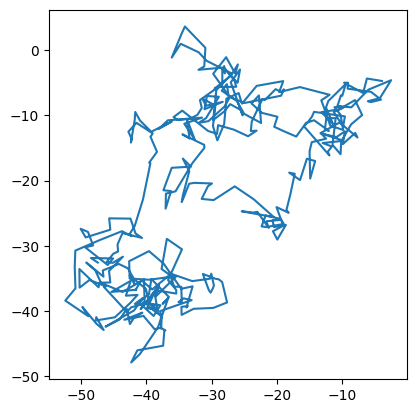

In [26]:
plt.figure()
plt.plot(*path.T)
plt.gca().set(aspect='equal')

## The Causal Entropic Force with Normal Noise 